In [ ]:
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.hysteresis import *

# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )


from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu
from OSCC_postprocessing.filters.bilateral_filter import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy

from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
from OSCC_postprocessing.binary_ops.masking import *
from OSCC_postprocessing.filters.convolution_2D_rawKernel import *
from OSCC_postprocessing.analysis.hysteresis import * 

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Postprocessing_Py\\.venv\\Lib\\site-packages\\cupy\\__init__.py'>


In [ ]:


def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)

In [ ]:
# The only manual inputs in this file
file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T12\1.cine")
json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T1\config.json")

In [ ]:

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits
gamma = 1.0

frames_before_SOI = 10
frame_limit = 80

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=100)
# Normalize the grayscale video to [0, 1] brightness range
video = xp.asarray(video)/ brightness_levels

F, H, W = video.shape

# Json file contains the metadata
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")


Video Info - Width: 768, Height: 768, Frames: 100
The injector has 10 plumes.
The nozzle is centred at (392.50, 378.37) in image coordinates.


In [ ]:
def mie_multihole_video_strip_processing(video,
                                         centre,  
                                         inner_radius, 
                                         outer_radius, 
                                         number_of_plumes, 
                                         init_frames=10,
                                         mask_angle_tolerance=1.2, 
                                         ):
    """
    Process a multi-hole injector video to extract individual plume segments.
    
    This function performs background subtraction, masking, angular density analysis,
    and rotates the video to extract individual plume strips for further analysis.
    
    Parameters
    ----------
    video : xp.ndarray
        Input video array with shape (Frames, Height, Width), normalized to [0, 1].
    centre : tuple of float
        (x, y) coordinates of the nozzle centre in image coordinates.
    inner_radius : float
        Inner radius of the ring mask (typically the injector radius).
    outer_radius : float
        Outer radius of the ring mask (typically the quartz window radius).
    number_of_plumes : int
        Number of plumes/holes in the injector.
    init_frames : int, optional
        Number of initial frames to use for background estimation. Default is 10.
    
    Returns
    -------
    segments : xp.ndarray
        Rotated video segments for each plume with shape (Plumes, Frames, H, W).
    segment_masks : xp.ndarray
        Binary masks for each rotated segment with shape (Plumes, 1, H, W).
    occupied_angles : list
        List of angular lengths for each detected plume region.
    average_occupied_angle : float
        Average angular width of the plumes in degrees.
    """
    # === Get video dimensions ===
    F, H, W = video.shape
    
    # === Background Subtraction ===
    # Use mean of first few frames as background reference
    bkg = xp.mean(video[:init_frames], axis=0)[None, :, :]
    foreground = video - bkg  # Subtract background (avoid in-place to preserve original)
    
    # === Apply Ring Mask ===
    # Create annular mask between inner and outer radius to focus on spray region
    ring_mask = generate_ring_mask(H, W, centre, inner_radius, outer_radius, xp)

    foreground *= ring_mask[None, :, :]  # Apply mask to all frames

    # === Compute Summed Frame for Analysis ===
    # Sum all frames and normalize for threshold-based segmentation
    video_sum_all_frame = _min_max_scale(xp.sum(foreground, axis=0) * 1.0)

    # Create binary mask using triangle thresholding to identify spray regions
    sum_mask = _triangle_binarize_gpu(video_sum_all_frame, ignore_zeros=True)

    # === Angular Signal Density Analysis ===
    # Use 720 bins for 0.5 degree resolution
    bins = 720
    # scale = bins / 360.0

    # Compute angular signal distribution around the nozzle centre
    _, total_angular_signal_density, _ = angle_signal_density_auto(
        video_sum_all_frame[None, :, :], centre[0], centre[1], N_bins=bins
    )

    # === Find Optimal Rotation Offset ===
    # Use FFT to find the best offset that aligns with plume periodicity
    offset = estimate_offset_from_fft(total_angular_signal_density, number_of_plumes)

    # Calculate rotation angles for each plume (evenly spaced with offset correction)
    angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - _as_numpy(offset)
    
    # === Compute Occupied Angles ===
    # Create bin-wise mask and fill small gaps to get continuous plume regions
    bin_wise_mask = fill_short_false_runs(
        _triangle_binarize_gpu(xp.sum(total_angular_signal_density, axis=0), ignore_zeros=True), 
        max_len=3
    )

    # Calculate angular span of each plume region
    occupied_angles = periodic_true_segment_lengths(bin_wise_mask)
    # Average angular width per plume in degrees
    average_occupied_angle = (bin_wise_mask.sum() / bins * 360.0 / number_of_plumes).item()

    # Generate 2D angular mask from the 1D signal density
    angular_mask = generate_angular_mask_from_tf(H, W, centre, total_angular_signal_density, bins)


    # === Combine All Masks ===
    # Final mask combines: triangle threshold mask + angular mask + ring mask
    final_mask = (sum_mask * angular_mask[:, :, 0])
    final_mask = (final_mask * ring_mask)

    # === Rotate Video to Extract Individual Plume Strips ===
    segments = []
    # Output shape for rotated strips (reduced height for efficiency)
    OUT_SHAPE = (H // 4, W // 2)

    for idx, angle in enumerate(angles):
        # Rotate video so current plume is horizontal (nozzle at left edge)
        segment, _, _ = rotate_video_nozzle_at_0_half_backend(
                video,
                centre, 
                angle,
                interpolation="bilinear",
                border_mode="constant",
                out_shape=OUT_SHAPE,
            )
        segments.append(segment)

    # Stack all segments: shape (Plumes, Frames, H, W)
    segments = xp.stack(segments, axis=0)
    # Clip to valid range and convert to float16 for memory efficiency
    segments = xp.clip(segments, 0.0, 1.0).astype(xp.float16)


    # Generate triangular plume mask to isolate each plume from neighbours
    # The mask width is 2x the average occupied angle to capture the full plume
    plume_mask = generate_plume_mask(segments.shape[3], segments.shape[2], angle=average_occupied_angle*mask_angle_tolerance, x0=inner_radius)
    # Convert NumPy mask to backend array (CuPy/NumPy) for GPU compatibility
    plume_mask = xp.asarray(plume_mask)

    # === Rotation of final masks for each plume ===
    # Rotate the combined mask to match each plume's orientation
    segment_masks = []

    for idx, angle in enumerate(angles):
        segment_mask, _, _ = rotate_video_nozzle_at_0_half_backend(
                final_mask[None, :, :],
                centre, 
                angle,
                interpolation="nearest",
                border_mode="constant",
                out_shape=OUT_SHAPE,
            )
        segment_masks.append(segment_mask)

    # Stack masks: shape (Plumes, 1, H, W)
    # BUG FIX: was previously stacking 'segments' instead of 'segment_masks'
    segment_masks = xp.stack(segment_masks, axis=0)

    # Apply plume angular mask to segment masks using bitwise AND
    # plume_mask[None, None, :, :] broadcasts to (1, 1, H, W)
    segment_masks = (segment_masks * plume_mask[None, None, :, :]).astype(xp.float16)

    return segments, segment_masks, occupied_angles, average_occupied_angle

In [ ]:
F, H, W = video.shape

# === Background Subtraction ===
# Use mean of first few frames as background reference
bkg = xp.mean(video[:frames_before_SOI], axis=0)[None, :, :]
foreground = video - bkg  # Subtract background (avoid in-place to preserve original)

# === Apply Ring Mask ===
# Create annular mask between inner and outer radius to focus on spray region
ring_mask = generate_ring_mask(H, W, centre, ir_, or_, xp)

foreground *= ring_mask[None, :, :]  # Apply mask to all frames


In [ ]:

# === Compute Summed Frame for Analysis ===
# Sum all frames and normalize for threshold-based segmentation
video_sum_all_frame = _min_max_scale(xp.sum(foreground, axis=0) * 1.0)

# Create binary mask using triangle thresholding to identify spray regions
sum_mask = _triangle_binarize_gpu(video_sum_all_frame, ignore_zeros=True)

In [121]:
def sobel_magnitude_video_strips(segments, frames_before_SOI=10, wsize=3, sigma=1):
    sobel_x = make_kernel("sobel", wsize, sigma, direction="x")
    sobel_y = make_kernel("sobel", wsize, sigma, direction="y")

    segments_high_pass = xp.zeros_like(segments)

    P, F, H, W = segments.shape
    for p in range(P):
        sb_filt_x = convolution_2D_cupy(segments[p], sobel_x)
        sb_filt_y = convolution_2D_cupy(segments[p], sobel_y)
        segments_high_pass[p] = xp.sqrt(sb_filt_x ** 2 + sb_filt_y ** 2)

    # segments_high_pass -= xp.mean(segments_high_pass[:, :frames_before_SOI, :, :], axis=1, keepdims=True)
    segments_high_pass -= xp.mean(segments_high_pass[:, :frames_before_SOI, :, :], axis=1, keepdims=True)
    for p in range(P):
        segments_high_pass[p] = _min_max_scale(xp.clip(segments_high_pass[p], 0, None))
        
    return segments_high_pass

In [122]:
def traingular_binarize_video_strips(segment, segment_masks=None, struct_filling=None, struct_closing=None):
    P, F, H, W = segment.shape

    if struct_filling is None:
        struct_filling = xp.zeros((3, 3, 3), dtype=bool)
        struct_filling[1, :, :] = True
    if struct_closing is None:
        struct_closing = xp.zeros((3, 3, 3), dtype=bool)
        struct_closing[1, :, :] = True
    if segment_masks is not None:
        seg_hp_bw_filled = triangle_binarize_gpu(segment) * segment_masks

    else:
       seg_hp_bw_filled = triangle_binarize_gpu(segment) 
 
    for p in range(P):
        blob_3D = keep_largest_component_nd_cuda(
            cndi.binary_fill_holes(
                cndi.binary_closing(
                    seg_hp_bw_filled[p], structure=struct_closing
                )
                , structure=struct_filling)
            )
        for f in range(F):
            seg_hp_bw_filled[p, f] = keep_largest_component_cuda(blob_3D[f])
    return seg_hp_bw_filled

In [123]:
def compensate_foreground_gain(foreground_segments):
    # Remember to subtract the background before this step

    P, F, H, W = foreground_segments.shape

    # frame_wise_sums has shape (P, F)
    frame_wise_sums = xp.sum(foreground_segments, axis=(2,3))

    # Find the brightest frame and their intensity for each plume
    brightness_peaks = xp.argmax(frame_wise_sums, axis=1)
    peak_intensity_sums = xp.max(frame_wise_sums, axis=1)

    # Normalize the intensity of the brightest frame to 1 for each plume
    frame_wise_sums /= peak_intensity_sums[:, None]

    # Try energy based gain compensation on the highpass filtered video
    gain_curves = cp.ones_like(frame_wise_sums)

    eps = 1e-9
    for p, frame_wise_sum in enumerate(frame_wise_sums):
        # Correct the gain compensation after the brightest frame,
        # Assume they decline after the brightest frame,
        # And there is only one peak 
        gain_curves[p, int(brightness_peaks[p]):] = 1.0/(eps+frame_wise_sum[int(brightness_peaks[p]):])

    # Apply the gain compensation
    compensated_segments = foreground_segments * gain_curves[:, :, None, None]

    return compensated_segments # (P, F, H, W)





In [124]:
def calculate_penetration_bw_num_pixelsthreshold(segments_bw, inner_radius, outer_radius, thres_num_bw=1):

    edge_bw_col_sums = xp.sum(segments_bw, axis=2) > thres_num_bw

    pen_edge_bw = xp.swapaxes(edge_bw_col_sums , 1, 2)

    penetration_highpass = pen_edge_bw.shape[1] - cp.argmax(pen_edge_bw[:, ::-1, :], axis=1)
    penetration_highpass = penetration_highpass.astype(cp.float32)  # 或 cp.float64
    penetration_highpass[penetration_highpass > outer_radius ] = cp.nan
    penetration_highpass -= inner_radius
    return penetration_highpass

In [ ]:
# Executions part

segments, segment_masks, occupied_angles, average_occupied_angle = mie_multihole_video_strip_processing(video,
                                                                                                        centre,  
                                                                                                        ir_, 
                                                                                                        or_, 
                                                                                                        number_of_plumes, 
                                                                                                        init_frames=10,)
# High pass filtering to find the edge responses                                                                           init_frames=10,)  
segments_high_pass = sobel_magnitude_video_strips(segments)

# Compensate the gain of the high pass filtered video
segments_highpass_compensated = compensate_foreground_gain(segments_high_pass)  

# Morphological operations
struct1 = cp.zeros((3, 3, 3), dtype=bool)
struct1[1, :, :] = True

struct2 = cp.ones((3,3,3), dtype=bool)

# Binarize and refine by filling the holes and closing the edges
segments_highpass_bw = traingular_binarize_video_strips(segments_highpass_compensated, segment_masks=segment_masks, struct_filling=struct1, struct_closing=struct2)

# Calculate the penetration from the time-distance intensity heatmap
penetration_highpass = calculate_penetration_bw_num_pixelsthreshold(segments_highpass_bw, ir_, or_, thres_num_bw=1)

# Calculate the first derivative of the penetration
penetration_diff = xp.diff(penetration_highpass, axis=1)

# Remove the negative penetration difference
diff_threshold = -3
x_loc, y_loc = xp.where(penetration_diff < diff_threshold)

for plume_idx, frame_idx in zip(x_loc, y_loc):
    penetration_highpass[plume_idx, frame_idx-1:] = xp.nan

TF = ~ xp.isnan(penetration_highpass)

P, F = TF.shape
for p in range(P):
    
    TF[p] = remove_short_true_runs(TF[p], min_len=5)



Text(0.5, 1.0, 'Penetration from the binarizedhigh pass filtered video')

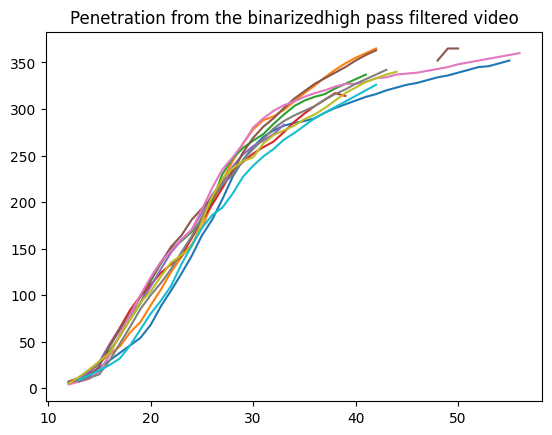

In [126]:
plt.plot(penetration_highpass.T.get())

plt.title("Penetration from the binarizedhigh pass filtered video")



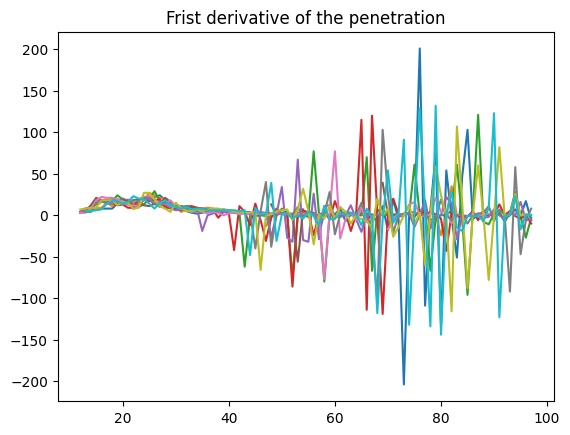

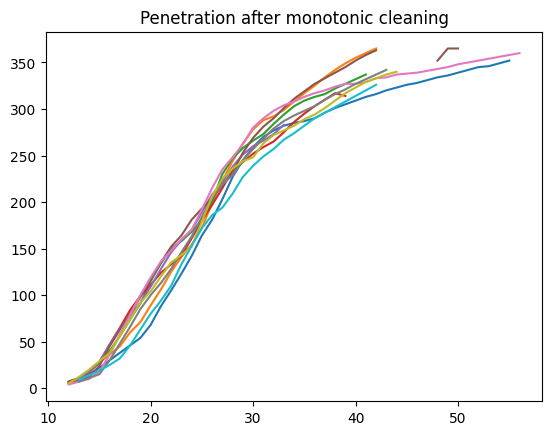

In [127]:

plt.plot(penetration_diff.T.get())
plt.title("Frist derivative of the penetration")
plt.show()

plt.plot(penetration_highpass.T.get())
plt.title("Penetration after monotonic cleaning")
plt.show()


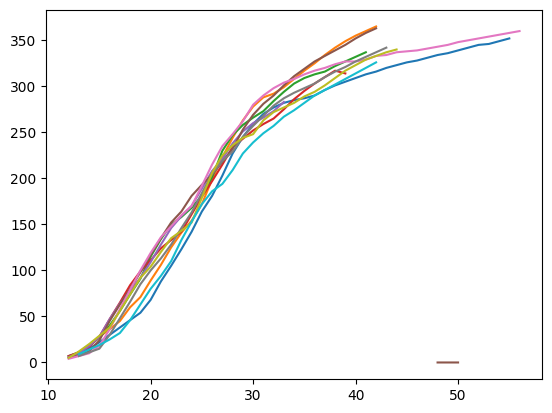

In [ ]:


TF = ~ xp.isnan(penetration_highpass)

P, F = TF.shape

for p in range(P):
    
    TF[p] = remove_short_true_runs(TF[p], min_len=5)



plt.plot((penetration_highpass* TF).T.get()) 